# 1. Carga y Preprocesamiento de Datos 

Primero, importamos las librerías necesarias y cargamos los datasets. Luego, realizamos las tareas de limpieza y unión de datos para tener un DataFrame consolidado con el que trabajar.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# 1. Cargar los datos
try:
    df_telecom = pd.read_csv('telecom_dataset_us.csv')
    df_clients = pd.read_csv('telecom_clients_us.csv')
    print("Datos cargados exitosamente.")
except FileNotFoundError:
    print("Asegúrate de que los archivos CSV están en el directorio correcto.")

Datos cargados exitosamente.


In [5]:
# 2. Inspección inicial
print("\n--- Inspección de telecom_dataset_us ---")
print(df_telecom.info())
print("\n--- Inspección de telecom_clients_us ---")
print(df_clients.info())


--- Inspección de telecom_dataset_us ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None

--- Inspección de telecom_clients_us ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ---

In [6]:
# 3. Limpieza de datos
# Convertir columnas de fecha a formato datetime
df_telecom['date'] = pd.to_datetime(df_telecom['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

# Calcular el tiempo de espera
df_telecom['wait_duration'] = df_telecom['total_call_duration'] - df_telecom['call_duration']

In [7]:
# 4. Unir los DataFrames
df_full = df_telecom.merge(df_clients, on='user_id', how='left')

print("\n--- DataFrame unido ---")
print(df_full.info())
print(df_full.head())


--- DataFrame unido ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
 9   wait_duration        53902 non-null  int64                    
 10  tariff_plan          53902 non-null  object  

# 2. Análisis Exploratorio de Datos (AED) 

En esta fase, definimos los criterios para la ineficacia y realizamos los primeros análisis para entender mejor el comportamiento de los operadores.

In [8]:
# 1. Análisis descriptivo
print("\n--- Estadísticas descriptivas de las duraciones de llamada ---")
print(df_full[['call_duration', 'total_call_duration', 'wait_duration']].describe())


--- Estadísticas descriptivas de las duraciones de llamada ---
       call_duration  total_call_duration  wait_duration
count   53902.000000         53902.000000   53902.000000
mean      866.684427          1157.133297     290.448870
std      3731.791202          4403.468763    1127.905654
min         0.000000             0.000000       0.000000
25%         0.000000            47.000000      17.000000
50%        38.000000           210.000000      55.000000
75%       572.000000           902.000000     201.000000
max    144395.000000        166155.000000   46474.000000


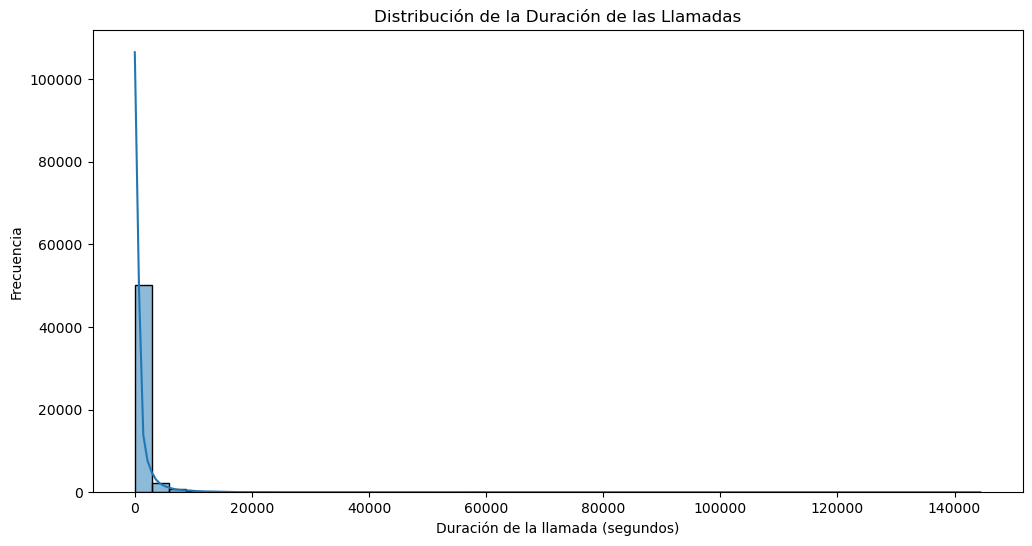

In [9]:
# 2. Visualización
plt.figure(figsize=(12, 6))
sns.histplot(df_full['call_duration'], bins=50, kde=True)
plt.title('Distribución de la Duración de las Llamadas')
plt.xlabel('Duración de la llamada (segundos)')
plt.ylabel('Frecuencia')
plt.show()

In [10]:
# 3. Definir y calcular métricas de ineficacia por operador
# Agrupar datos por operador para calcular métricas de rendimiento
operator_metrics = df_full.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_in_calls=('is_missed_call', lambda x: (x == True).sum()),
    total_in_calls=('direction', lambda x: (x == 'in').sum()),
    total_out_calls=('direction', lambda x: (x == 'out').sum()),
    avg_wait_duration=('wait_duration', 'mean')
).reset_index()

# Calcular el porcentaje de llamadas entrantes perdidas
operator_metrics['missed_in_rate'] = (operator_metrics['missed_in_calls'] / operator_metrics['total_in_calls']).fillna(0)

# Definir operadores ineficaces basados en los criterios
# Criterios: alto porcentaje de llamadas perdidas (ej. > 25%) y tiempo de espera prolongado (ej. > 100 segundos)
inefficient_operators = operator_metrics[
    (operator_metrics['missed_in_rate'] > 0.25) &
    (operator_metrics['avg_wait_duration'] > 100)
]

print("\n--- Operadores ineficaces (basado en criterios iniciales) ---")
print(inefficient_operators)


--- Operadores ineficaces (basado en criterios iniciales) ---
      operator_id  total_calls  missed_in_calls  total_in_calls  \
0        879896.0         1131               50              23   
1        879898.0         7974              100              64   
4        880026.0         2439               94              19   
5        880028.0         2906               91              45   
11       882684.0         1364               55              52   
...           ...          ...              ...             ...   
1059     968150.0          104                6               2   
1061     968338.0          275                7               7   
1066     969272.0          466               14              10   
1087     972410.0           77                2               0   
1088     972412.0           61                2               1   

      total_out_calls  avg_wait_duration  missed_in_rate  
0                 105         110.671875        2.173913  
1             

# 3. Prueba de Hipótesis

## 3.1 Comparar el tiempo de espera entre operadores eficaces e ineficaces.

In [11]:
# Separar los datos en dos grupos: ineficaces y eficaces
efficient_operators_data = df_full[~df_full['operator_id'].isin(inefficient_operators['operator_id'])]
inefficient_operators_data = df_full[df_full['operator_id'].isin(inefficient_operators['operator_id'])]

# Prueba de hipótesis (Prueba t de Student)
# H0: El tiempo de espera promedio es el mismo para ambos grupos.
# H1: El tiempo de espera promedio es mayor para los operadores ineficaces.
t_stat, p_value = stats.ttest_ind(
    inefficient_operators_data['wait_duration'].dropna(),
    efficient_operators_data['wait_duration'].dropna(),
    equal_var=False,  # Se asume varianzas desiguales
    alternative='greater'
)

print("\n--- Resultado de la Prueba de Hipótesis (Prueba t) ---")
print(f"Estadístico t: {t_stat:.2f}")
print(f"Valor p: {p_value:.3f}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula. El tiempo de espera es significativamente más largo para los operadores ineficaces.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula. La diferencia no es estadísticamente significativa.")


--- Resultado de la Prueba de Hipótesis (Prueba t) ---
Estadístico t: 43.66
Valor p: 0.000
Rechazamos la hipótesis nula. El tiempo de espera es significativamente más largo para los operadores ineficaces.


## 3.2 Analizar la relación entre el plan tarifario del cliente y el número de llamadas perdidas.

In [12]:
# Crear una tabla de contingencia
# Agrupamos por 'tariff_plan' y 'is_missed_call' para contar las ocurrencias
contingency_table = pd.crosstab(df_full['tariff_plan'], df_full['is_missed_call'])

print("\n--- Tabla de contingencia (Plan tarifario vs. Llamada perdida) ---")
print(contingency_table)

# Realizar la prueba de chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\n--- Resultado de la Prueba de Hipótesis 2 (Chi-cuadrado) ---")
print(f"Estadístico Chi-cuadrado: {chi2_stat:.2f}")
print(f"Valor p: {p_value:.3f}")
print(f"Grados de libertad (dof): {dof}")

# Interpretar el resultado
alpha = 0.05
if p_value < alpha:
    print(f"\nRechazamos la hipótesis nula con un nivel de significancia de {alpha}.")
    print("Existe una relación estadísticamente significativa entre el plan tarifario y si la llamada fue perdida.")
else:
    print(f"\nNo hay evidencia suficiente para rechazar la hipótesis nula con un nivel de significancia de {alpha}.")
    print("Las variables son independientes, lo que sugiere que el plan tarifario no está asociado con la tasa de llamadas perdidas.")


--- Tabla de contingencia (Plan tarifario vs. Llamada perdida) ---
is_missed_call  False  True 
tariff_plan                 
A                8786   6111
B               10491   8453
C               11057   9004

--- Resultado de la Prueba de Hipótesis 2 (Chi-cuadrado) ---
Estadístico Chi-cuadrado: 61.36
Valor p: 0.000
Grados de libertad (dof): 2

Rechazamos la hipótesis nula con un nivel de significancia de 0.05.
Existe una relación estadísticamente significativa entre el plan tarifario y si la llamada fue perdida.


# 4. Identificación de Operadores Ineficaces


--- Inspección de operadores ineficaces ---
<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, 0 to 1088
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   operator_id        348 non-null    float64
 1   total_calls        348 non-null    int64  
 2   missed_in_calls    348 non-null    int64  
 3   total_in_calls     348 non-null    int64  
 4   total_out_calls    348 non-null    int64  
 5   avg_wait_duration  348 non-null    float64
 6   missed_in_rate     348 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 21.8 KB
None

--- Conclusiones para la Presentación ---
Número de operadores identificados como ineficaces: 348
Características principales:
         operator_id   total_calls  missed_in_calls  total_in_calls  \
count     348.000000    348.000000       348.000000      348.000000   
mean   926256.310345   1990.557471        27.666667       16.540230   
std     21961.239127   541

c:\Users\WIN10\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


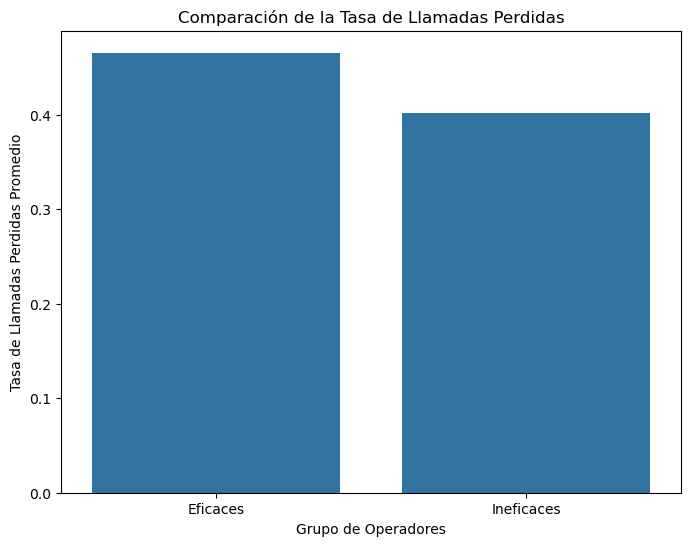

In [14]:
# 4. Identificación de Operadores Ineficaces
# La lista final de operadores ineficaces es 'inefficient_operators'
# Puedes guardar esta lista en un archivo CSV o continuar el análisis con ella
inefficient_operators.to_csv('operadores_ineficaces.csv', index=False)
print("\n--- Inspección de operadores ineficaces ---")
print(inefficient_operators.info())

# 5. Conclusiones y Preparación de la Presentación
# En esta sección, resumirías tus hallazgos clave
print("\n--- Conclusiones para la Presentación ---")
print(f"Número de operadores identificados como ineficaces: {len(inefficient_operators)}")
print("Características principales:")
print(inefficient_operators.describe())

# Puedes incluir visualizaciones adicionales como un gráfico de barras
# para comparar el porcentaje de llamadas perdidas entre los dos grupos.
plt.figure(figsize=(8, 6))
sns.barplot(x=['Eficaces', 'Ineficaces'], y=[
    efficient_operators_data['is_missed_call'].mean(),
    inefficient_operators_data['is_missed_call'].mean()
])
plt.title('Comparación de la Tasa de Llamadas Perdidas')
plt.xlabel('Grupo de Operadores')
plt.ylabel('Tasa de Llamadas Perdidas Promedio')
plt.show()